Epoch 1/60 - Train Loss: 0.8801 - Val Loss: 0.7649 - Accuracy: 90.57%
Epoch 2/60 - Train Loss: 0.7199 - Val Loss: 0.7344 - Accuracy: 90.82%
Epoch 3/60 - Train Loss: 0.6792 - Val Loss: 0.7079 - Accuracy: 91.79%
Epoch 4/60 - Train Loss: 0.6574 - Val Loss: 0.7173 - Accuracy: 91.30%
Epoch 5/60 - Train Loss: 0.6453 - Val Loss: 0.6956 - Accuracy: 92.36%
Epoch 6/60 - Train Loss: 0.6355 - Val Loss: 0.6856 - Accuracy: 92.68%
Epoch 7/60 - Train Loss: 0.6285 - Val Loss: 0.6784 - Accuracy: 92.93%
Epoch 8/60 - Train Loss: 0.6205 - Val Loss: 0.7048 - Accuracy: 91.60%
Epoch 9/60 - Train Loss: 0.6134 - Val Loss: 0.6809 - Accuracy: 92.90%
Epoch 10/60 - Train Loss: 0.6072 - Val Loss: 0.7025 - Accuracy: 91.89%
Epoch 11/60 - Train Loss: 0.6021 - Val Loss: 0.7114 - Accuracy: 91.71%
Epoch 12/60 - Train Loss: 0.5970 - Val Loss: 0.7010 - Accuracy: 92.37%
Epoch 13/60 - Train Loss: 0.5893 - Val Loss: 0.6737 - Accuracy: 92.88%
Epoch 14/60 - Train Loss: 0.5890 - Val Loss: 0.6916 - Accuracy: 92.30%
Epoch 15/60 - T

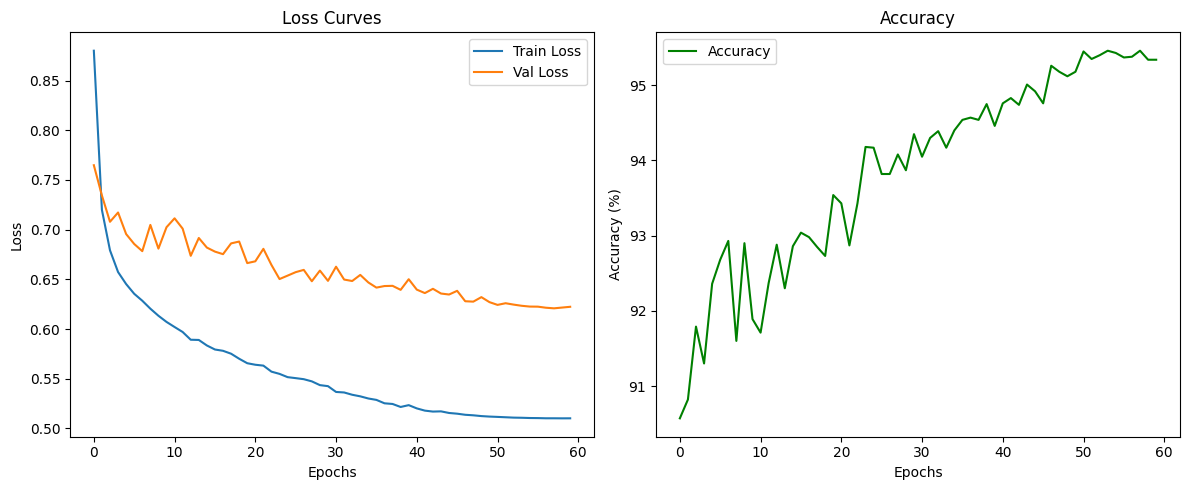

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

for name, param in model.named_parameters():
    if "layer3" in name or "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, 10)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0003, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=60)

train_losses, val_losses, accuracies = [], [], []

for epoch in range(60):
    model.train()
    total_loss = 0
    for imgs, labels in trainloader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(trainloader))

    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in testloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_losses.append(val_loss / len(testloader))
    acc = 100 * correct / total
    accuracies.append(acc)

    scheduler.step()
    print(f"Epoch {epoch+1}/60 - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f} - Accuracy: {acc:.2f}%")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label="Accuracy", color="green")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.tight_layout()
plt.show()
